# Steps

In [1]:
# Define the problem
    # Binary classification

# Data Access
    # (.info(), describe(), .shape, .head(), .tail(), isnull(), .value_counts())
# Exploratory Data Analysis (EDA)
    # univariate analysis, bivariate analysis, (.distplot(), .countplot(), .boxplot(), .scatterplot(), .pairplot()), 
    # distribution (.histplot())
    # corellation (.heatmap())

# Data Preprocessing
    # from sklearn.model_selection import train_test_split
    # from sklearn.preprocessing import StandardScaler
    # data types, data mixture, shape, outliers, missing values, noisy data, skewness and kurtosis
# Model Building
    # from sklearn.linear_model import LogisticRegression,
    # from sklearn.neural_network import MLPClassifier
    # from sklearn.svm import LinearSVC
    # from sklearn.ensemble impor AdaBoostClassifier
    # from sklearn.naive_bayes import GaussianNB
    
# Model Validation
    # from sklearn.pipeline import Pipeline
    # from sklearn.model_selection import KFold, cross_val_score
    # from sklearn.model_selection import StratifiedKFold, KFold
    # from sklearn.model_selection import GridSearchCV
# Model Execution
    # Confusion Matrix: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).
    # Precision: A measure of a classifiers exactness.
    # Recall: A measure of a classifiers completeness
    # F1 Score (or F-score): A weighted average of precision and recall.
# Deployment

In [61]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier 
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hpsklearn import any_preprocessing
from hyperopt import tpe

In [3]:
seed = np.random.seed(147)

In [4]:
def data_load() -> list:
    """ """
    
    train_data = pd.read_csv("project_data/train_data.csv", header=None)
    test_data = pd.read_csv("project_data/test_data.csv", header=None)
    train_labels = pd.read_csv("project_data/train_labels.csv", header=None)
    
    return [train_data, test_data, train_labels]

In [5]:
train_data, test_data, train_labels = data_load()

In [6]:
train_labels_ravel = train_labels.values.ravel()

# Preprocessing

### problem: multidimensional dataset, 
### solution: dimensional reduction (Correlation Heatmap, Univariate Selection/ PCA - Principal Component Analysis/ RFE - Recursive Feature Elimination)

In [66]:
def pipe_std_minmax(data: pd.DataFrame = train_data) -> np.array:
    """ """
    
    # data standardization and normalization
    pipe = Pipeline([
    ("std", StandardScaler()),
    ("minmax", MinMaxScaler())
    ])
    
    # fit transform method
    train_std_minmax = pipe.fit_transform(data)
    
    return train_std_minmax

In [8]:
train_std_minmax = pipe_std_minmax()

In [11]:
# 1/3 kbest features
k=int(len(train_data.columns)/3)

In [13]:
def univariate_select(X: np.array = train_std_minmax, y: np.array = train_labels_ravel, n_of_kbest=k) -> np.array:
    """Univariate Selection"""
    
    print(f"Shape before: {X.shape}\n")
    
    # feature extraction 
    test = SelectKBest(score_func=f_classif, k=n_of_kbest)
    fit = test.fit(X, y)
    features = fit.transform(X)
    
    # summarize selected features
    scores = fit.scores_
    score_df = pd.DataFrame(scores, columns=["Scores"])
    print(f"Min score: {min(score_df.Scores)}, max score: {max(score_df.Scores)}, mean score: {np.mean(score_df.Scores)}\n")    
    print(f"Shape after: {features.shape}\n")
    
    score_df.drop(score_df[score_df.Scores < 1].index, inplace=True)
    l = len(score_df)
    
    if l != n_of_kbest:
        return univariate_select(n_of_kbest=l)
    else:
        return features

In [14]:
univariate_train = univariate_select()

Shape before: (3750, 10000)

min score: 1.7567042700994732e-09, max score: 17.321255892491074, mean score: 1.000380011727586

Shape after: (3750, 3333)

Shape before: (3750, 10000)

min score: 1.7567042700994732e-09, max score: 17.321255892491074, mean score: 1.000380011727586

Shape after: (3750, 3177)



In [18]:
def pca_select(X: np.array = univariate_train) -> np.array:
    """Principal Component Analysis"""
    
    print(f"Shape before: {X.shape}\n")
    
    # feature extraction
    pca = PCA(n_components=100, random_state=seed)
    fit = pca.fit(X)
    features = fit.transform(X)
    
    # summarize components
    print(f"Explained Variance: \n{fit.explained_variance_ratio_}\n")
    print(f"Shape after: {features.shape}")
    
    return features

In [19]:
pca_train = pca_select()

Shape before: (3750, 3177)

Explained Variance: 
[0.00119644 0.0011572  0.00114932 0.00114815 0.00114109 0.00113676
 0.0011336  0.00113102 0.00112559 0.00112421 0.00111666 0.00111646
 0.00111411 0.00110989 0.00110611 0.00110364 0.00109874 0.00109676
 0.00109307 0.00109102 0.0010901  0.00108277 0.00108163 0.0010793
 0.00107742 0.00107588 0.00107237 0.00106929 0.00106777 0.00106614
 0.00106504 0.00106352 0.0010601  0.00105923 0.00105696 0.00105041
 0.00104802 0.00104656 0.00104519 0.00104268 0.00104112 0.00104055
 0.00103838 0.00103691 0.00103446 0.00102977 0.0010284  0.00102667
 0.00102507 0.00102168 0.00101906 0.00101652 0.00101368 0.00101249
 0.00101097 0.00101016 0.00100867 0.00100588 0.00100427 0.00100261
 0.00100051 0.00099868 0.00099487 0.00099332 0.00099223 0.00098997
 0.00098815 0.00098489 0.00098367 0.00098203 0.00097907 0.00097823
 0.00097593 0.00097449 0.00096828 0.00096637 0.00096389 0.00096264
 0.00096064 0.00095803 0.00095728 0.00095593 0.00095393 0.00095246
 0.00095021 0.

In [21]:
def rfe_select(X: np.array = pca_train, y: np.array = train_labels_ravel) -> np.array:
    """Recursive Feature Elimination"""
    
    print(f"Shape before: {X.shape}\n")
    
    # feature extraction
    svc = SVC(kernel="linear", C=1, random_state=seed)
    rfe = RFE(estimator=svc, n_features_to_select=5)
    fit = rfe.fit(X, y)
    features = fit.transform(X)
    
    # summarize components
    print(f"Feature Ranking: \n{fit.ranking_}\n")
    print(f"Shape after: {features.shape}\n")
    
    return features

In [22]:
rfe_train = rfe_select()

Shape before: (3750, 100)

Feature Ranking: 
[ 1 12  1 79 78  1  2  4 83 72  9 47  7 76 63 82 46  1  5 66 15 23 96 30
 48  3 61 77 55 13 85 42 81 18 32 53 27 68 25 57 69 20 28 24 11 80 10 40
 59 75 43 70 67 87 93 26 52 31 21 90 39 62 14  8 35 34 88 95 29 58 56 84
 54  6 71 22 86 33 49 74 65 17 37 45 41 89 50 60 44  1 36 91 19 51 92 38
 64 16 94 73]

Shape after: (3750, 5)



### problem: unbalanced dataset, 
### solution: Random Oversampling/SMOTE

In [24]:
from imblearn.pipeline import Pipeline

In [25]:
def random_sampling(X: np.array = rfe_train, y: np.array = train_labels_ravel) -> list:
    """Random Oversampling/Undersampling"""
    
    #print(f"Value count before y resampled: {y.value_counts()}\n")
    
    # define pipeline
    over = RandomOverSampler(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    # fit and apply the pipeline
    X_resampled, y_resampled = pipeline.fit_resample(X, y)
    #print(f"Value count after y resampled: {y_resampled.value_counts()}\n")
    
    return [X_resampled, y_resampled]

In [26]:
X_resampled, y_resampled = random_sampling()

In [72]:
def save_data(X: np.array = X_resampled, y: np.array = y_resampled) -> None:
    """ """
    
    # save to npy file
    np.save('project_data/processed_train_X.npy', X)
    np.save('project_data/processed_train_y.npy', y)
    print("Saving has been completed.")

In [73]:
save_data()

Saving has been completed.


# EDA part 2

In [29]:
df = pd.DataFrame(X_resampled, index=None, columns=None)

In [30]:
def correlation_heatmap(data: pd.DataFrame = df) -> plt:
    """ """
    
    plt.figure(figsize=(16.9, 8))
    heat_mask = np.triu(np.ones_like(data.corr(), dtype=bool))
    sns.heatmap(data.corr(), mask=heat_mask, vmin=-1, vmax=1, annot=True)
    plt.title("Correlation heatmap for sliced train data")
    
    return plt.show()

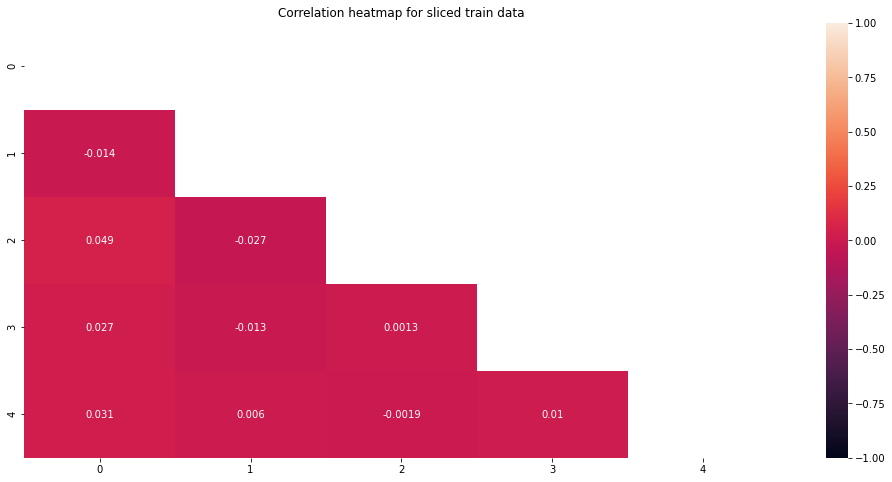

In [31]:
correlation_heatmap()

In [32]:
def pair_plot(data: pd.DataFrame = df) -> plt:
    """ """

    plt.figure(figsize=(14,8))    
    g = sns.pairplot(data, corner=True)
    g.fig.suptitle("Pair plot for preprocessed data")

    return plt.show()

<Figure size 1008x576 with 0 Axes>

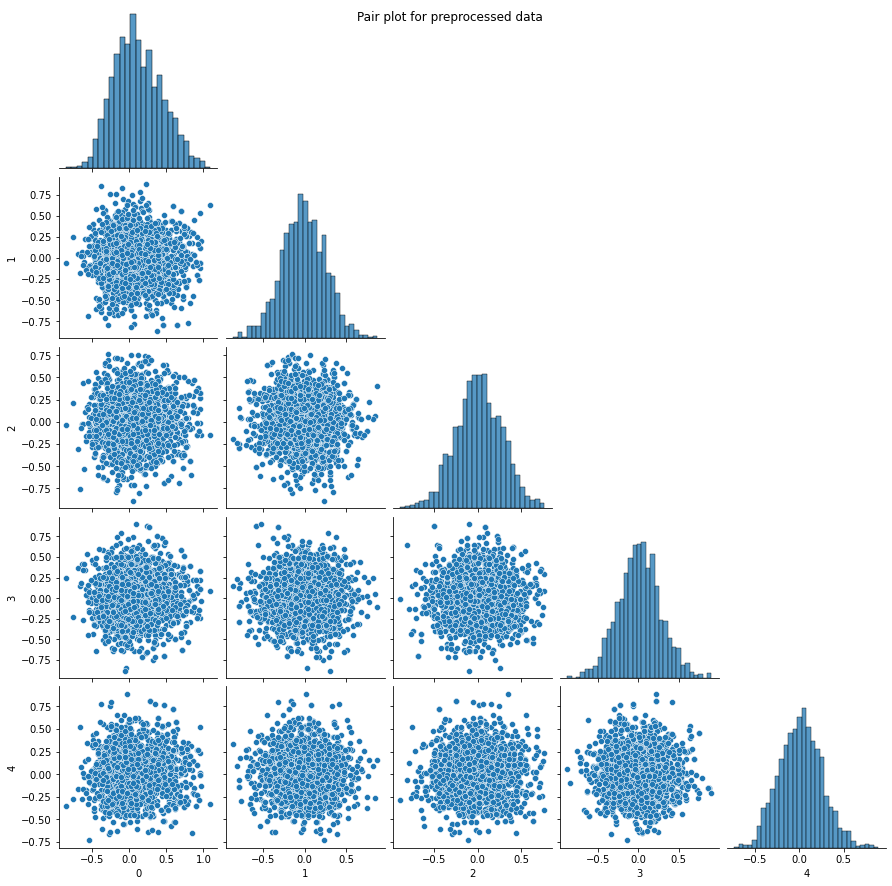

In [33]:
pair_plot()

In [34]:
def box_plot(data: pd.DataFrame = df) -> plt:
    """ """
    
    plt.figure(figsize=(15.2, 8))
    sns.boxplot(data=data)
    plt.title("Box plot for preprocessed data")
    
    return plt.show()

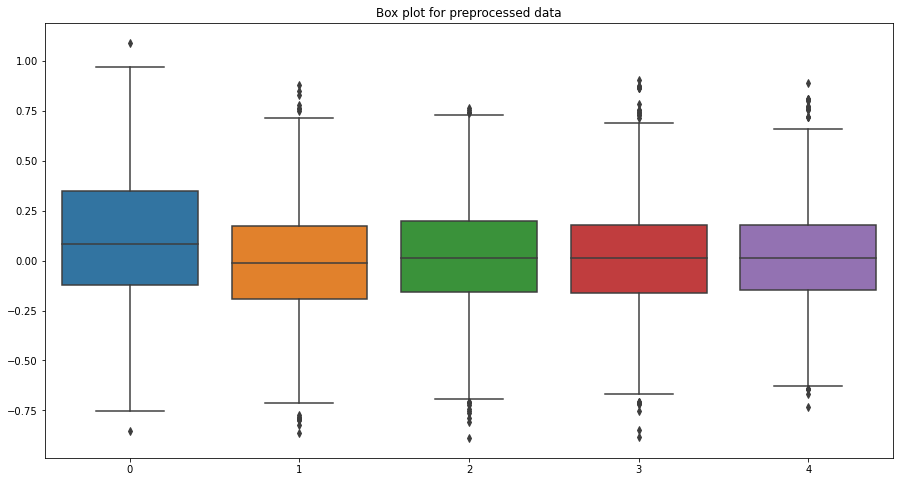

In [35]:
box_plot()

In [36]:
def scatter_plot(X: np.array = X_resampled, y: np.array = y_resampled) -> plt:
    """ """

    # summarize class distribution
    counter = Counter(y)

    # scatter plot of examples by class label
    plt.figure(figsize=(15.1, 13))
    for label, _ in counter.items():
        row_ix = np.where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label), 
                    s=100, marker="o", alpha=0.5, edgecolor="black")
    plt.title(f"Scatter plot for preprocessed data with {counter}")
    plt.legend()
    
    return plt.show()

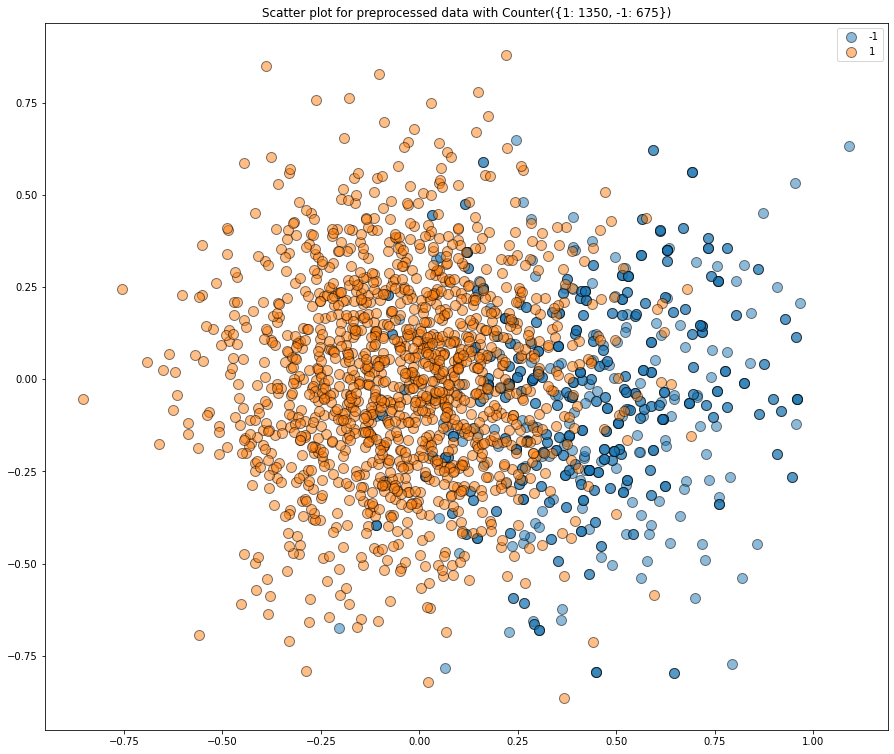

In [37]:
scatter_plot()

# Basic Models

In [38]:
# train test splitting
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=seed)

In [63]:
def pipe_basic_model(X_train, X_test, y_train, y_test: np.array) -> None:
    """ """
    
    pipe = Pipeline([("classifier", SVC(kernel="linear", C=1, random_state=seed))])
    
    # base line model picking
    search_space = [
        {"classifier": [SVC(random_state=seed)]},
        {"classifier": [LinearSVC(random_state=seed)]},
        {"classifier": [LogisticRegression(random_state=seed)]},
        {"classifier": [KNeighborsClassifier()]},
        {"classifier": [MLPClassifier(random_state=seed)]},
        {"classifier": [AdaBoostClassifier(random_state=seed)]},
        {"classifier": [GradientBoostingClassifier(random_state=seed)]},
        {"classifier": [RandomForestClassifier(random_state=seed)]},
        {"classifier": [ExtraTreesClassifier(random_state=seed)]},
        {"classifier": [AdaBoostClassifier(random_state=seed)]},
        {"classifier": [GaussianNB()]}
    ]
    
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)
    gridsearch = GridSearchCV(pipe, search_space, cv=cv, verbose=1, n_jobs=-1)
    best_model = gridsearch.fit(X_train, y_train)
    
    print(f"\nBest model: {best_model.best_estimator_.get_params()['classifier']}")
    #print(f"\nBest score: {best_model.best_score_}")
    acc = best_model.score(X_test, y_test)
    print(f"\nAccuracy: {acc}")

In [64]:
pipe_basic_model(X_train, X_test, y_train, y_test)

Fitting 30 folds for each of 11 candidates, totalling 330 fits

Best model: ExtraTreesClassifier()

Accuracy: 0.9171597633136095


In [58]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [59]:
def hyperopt_model(X_train, X_test, y_train, y_test: np.array) -> None:
    """ """
    
    # hyperopt defining
    model = HyperoptEstimator(
        classifier=any_classifier("cla"),
        preprocessing=any_preprocessing("pre"),
        algo=tpe.suggest,
        max_evals=10,
        trial_timeout=30,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    print(f"\nBest model: {model.best_model()}")
    acc = model.score(X_test, y_test)
    print(f"\nAccuracy: {acc}")

In [60]:
hyperopt_model(X_train, X_test, y_train, y_test)

100%|██████████████████████████████████████| 10/10 [00:01<00:00,  1.46s/trial, best loss: 0.09539473684210531]

Best model: {'learner': ExtraTreesClassifier(bootstrap=True, criterion='entropy',
                     max_features=0.1534941772925721, n_estimators=70,
                     n_jobs=-1, random_state=0, verbose=False), 'preprocs': (StandardScaler(with_std=False),), 'ex_preprocs': ()}

Accuracy: 0.9171597633136095
